### Deepseek Model İncelemesi ###

Deepseek modeli ortaya çıktığından itibaren ses getirdi. Ses getirmesinin sebebi düşük maaliyetle daha iyi model kalitesi sunmasıydı. Bu zamana kadar bir çok model açıkladım ve yaklaşımlarını hep birlikte inceledik. Deepseek modeline kadar yaygın yaklaşım KV Cache ile hesaplama yükünü düşürmekti. Ancak KV Cache'in sıkıntısı da depolama alanı gerektirmesiydi. Deepseek modelinin çözdüğü sorunlardan biri buydu. Onun dışında geleneksel yaklaşımlardan RMSNorm, RoPE Embedding, MLP kullanılmıştır. MoE yapısı da kullanılmıştır. Bütün bu yapılar açıklanacaktır.

Deepseek Repo: https://github.com/deepseek-ai/DeepSeek-V3/blob/main/inference/model.py

In [ ]:
#Matematiksel işlemler için
import math
#Veri sınıflarını tanımlama için
from dataclasses import dataclass
#Fonksiyon imzalarında veri tiplerini belirtmek için
from typing import Tuple, Optional, Literal

# Klasik yapay zeka işlemleri
import torch
from torch import nn
import torch.nn.functional as F
# Dağıtık hesaplama için
import torch.distributed as dist

from kernel import act_quant, weight_dequant, fp8_gemm

In [ ]:
# Öncelikle model parametreleri ile başlayalım. Deepseek modeli distributed eğitilebilmesi adına world_size adında bir parametre
# barındırır. Bu parametre GPU sayısını temsil eder. Eğer 1'den büyükse daha sonra bahsedilecek bazı tensörler bu GPU'lara dağıtılır.
world_size = 1
# query matrisinin latent'i
rank = 0
block_size = 128
# Matris çarpımı için parametre tipi
gemm_impl: Literal["bf16", "fp8"] = "bf16"
# Attention implementasyon tekniği
attn_impl: Literal["naive", "absorb"] = "absorb"

@dataclass
class ModelArgs:
    """
    Model argümanlarını ve hiperparametrelerini tanımlayan veri sınıfı.

    Attributes:
        max_batch_size (int): Maksimum batch size.
        max_seq_len (int): Maksimum uzunluk.
        dtype (Literal["bf16", "fp8"]): Hesaplama için veri tipi.
        scale_fmt (Optional[str]): Kuantizasyon ölçüsü için format.
        vocab_size (int): Sözlük uzunluğu.
        dim (int): Model boyutu.
        inter_dim (int): MLP katmanı için aradaki boyut (Hidden size).
        moe_inter_dim (int): MoE katmanı için aradaki boyut (Hidden size).
        n_layers (int): Transformer katman sayısı.
        n_dense_layers (int): Modeldeki dense layer sayısı.
        n_heads (int): Attention head sayısı.
        n_routed_experts (int): MoE katmanı için yönlendirilen uzman (expert) sayısı.
        n_shared_experts (int): MoE katmanı için paylaşılan uzman (expert) sayısı.
        n_activated_experts (int): MoE katmanındaki aktive edilmiş uzman sayısı.
        n_expert_groups (int): Expert grup sayısı.
        n_limited_groups (int): MoE yönlendirmesi için limitli grup sayısı.
        score_func (Literal["softmax", "sigmoid"]): MoE yönlendirmesi (routing) için skor fonksiyonu.
        route_scale (float): Routing skoru için ölçek faktörü.
        q_lora_rank (int): Query projeksiyonu için LoRA(Low Rank Adaptation) rank'ı.
        kv_lora_rank (int): Key-Value projeksiyonu için LoRA(Low Rank Adaptation) rank'ı.
        qk_nope_head_dim (int): Rotary embedding'ten geçmemiş key-query projeksiyon boyutu.
        qk_rope_head_dim (int): Rotary embedding'ten geçmiş key-query projeksiyon boyutu.
        v_head_dim (int): Value projeksiyonu için boyut.
        original_seq_len (int): Orijinal sequence length (dizi uzunluğu).
        rope_theta (float): Rotary positional encoding için base theta değeri.
        rope_factor (float): Genişletilmiş sequence length (dizi uzunluğu) için ölçekleme faktörü.
        beta_fast (int): Hızlı beta korelasyon faktörü.
        beta_slow (int): Yavaş beta korelasyon faktörü.
        mscale (float): Uzun süreli attention için ölçekleme faktörü.
    """
    max_batch_size: int = 8
    max_seq_len: int = 4096 * 4
    dtype: Literal["bf16", "fp8"] = "bf16"
    scale_fmt: Optional[str] = None
    vocab_size: int = 102400
    dim: int = 2048
    inter_dim: int = 10944
    moe_inter_dim: int = 1408
    n_layers: int = 27
    n_dense_layers: int = 1
    n_heads: int = 16
    # moe
    n_routed_experts: int = 64
    n_shared_experts: int = 2
    n_activated_experts: int = 6
    n_expert_groups: int = 1
    n_limited_groups: int = 1
    score_func: Literal["softmax", "sigmoid"] = "softmax"
    route_scale: float = 1.
    # mla
    q_lora_rank: int = 0
    kv_lora_rank: int = 512
    qk_nope_head_dim: int = 128
    qk_rope_head_dim: int = 64
    v_head_dim: int = 128
    # yarn
    original_seq_len: int = 4096
    rope_theta: float = 10000.0
    rope_factor: float = 40
    beta_fast: int = 32
    beta_slow: int = 1
    mscale: float = 1.

Normalizasyon kısmı ile başlayalım. Klasik transformer modellerinde normalizasyon işlemi ortalama ve varyans yardımıyla bulunur ve
(x - mean) / var şeklinde formül uygulanır. Bu da  veri dağılımını ortalaması 0'a varyansı 1'e yakın hale getirmeye çalışır ve Gaussian dağılıma benzetir. Ancak bazı modellerde bu yaklaşım yerine RMSNormalization yaklaşımı izlenmektedir. Burada ortalamaların karelerinin karekökü alınır. Ayrıca RMSNorm yöntemi klasik Layer Normalization yönteminden daha az işlem ve parametre içermektedir. Büyük modellerde ortalama çıkarma işlemi küçük farkların büyümesine de neden olabileceğinden RMSNorm yönteminde ortalama çıkarılmaz.

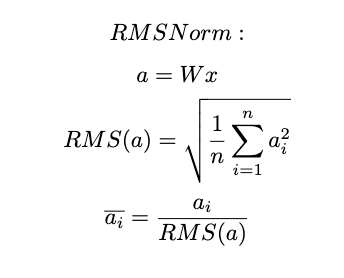

In [ ]:
# Orijinal kodtaki RMSNorm'da direkt olarak F.RMSNorm kullanılmış ama bu şekilde de kullanmada sakınca yok. Fonksiyon formülüyle gösterildi
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.dim = dim
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, x: torch.Tensor):
      rm = (x**2).mean(dim = -1, keepdim = True)
      return x * (self.weight / (rm + self.eps) **0.5)

## Rope Embedding ve Embedding İncelemesi ##

Gelişmiş modellerde geleneksel transformerlardan farklı olarak Embedding vektörü reel olmayan düzlemden Euler formülü aracılığıyla türetilir. Klasik Transformer modellerinde, kelime embedding’lerine ek olarak bir pozisyon (sıra) embedding’i oluşturulur ve bu iki vektör toplanarak modele pozisyon bilgisi kazandırılır. Ancak bu yaklaşım mutlak (absolute) konum bilgisi içerdiğinden, giriş dizisinin uzunluğu context_length parametresini aştığında pozisyon bilgisinin genellenebilirliği zayıflar. Bu sorunu aşmak için, gelişmiş modellerde sinüs ve kosinüs fonksiyonlarının periyodik yapısından yararlanan RoPE (Rotary Positional Embedding) yöntemi kullanılmaktadır.

## Absolute Ve Relative Positional Encoding Arasındaki Farklar ##

Absolute positional encoding ilgili tokenın cümledeki pozisyon bilgisini içereceğinden her seferinde bir tokenla uğraşır ancak relative positional encoding bu pozisyon bilgisinin yanı sıra iki token arasındaki mesafe bilgisini de içereceğinden dolayı her seferinde iki token ile uğraşır.

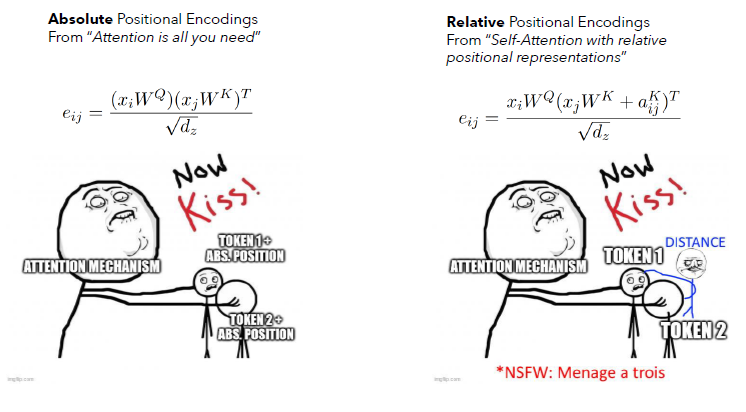

[Kaynak - Umar Jamil Coding LLaMA 2 From Scratch]

Yukarıdaki şekilde de görüldüğü üzere geleneksel transformer mimarisinde formülümüz Q @ K.T / sqrt(dim) şeklinde iken relative positional encodingte Q @ (K + dist_matrix).T / sqrt(dim) şekline gelmiştir. Bu da vektörlerin sıra bilgisiyle değil birbirleri arasındaki mesafe ile tutulduğunu gösterir. Bu yaklaşım zero-shot'ta yüksek performans gösterir.
Rotary Positional Encoding paperının yazarları işlemleri inner product ile yapmıştır. Bu da dot productın reel olmayan düzlemdeki hali gibi düşünülebilir.

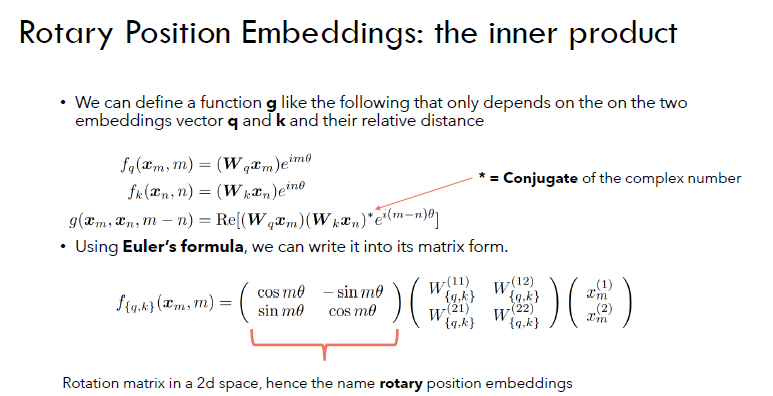

[Kaynak - Umar Jamil]

Yukarıdaki şekilde de görüldüğü üzere key ve query matrisleri mesafeleri de içeren bir g fonksiyonuna çevrildiğinde ve Euler formülü de kullanıldığında kosinüs ve sinüs elde ederiz. Buradaki kosinüs ve sinüslü matris de döndürme matrisi (rotation matrix)tir. Ancak bu işlem 2 boyutlu düzlemdedir. Bunu çok boyutlu düzleme aktarırsak aşağıdaki şekildeki gibi bir matris elde ederiz.

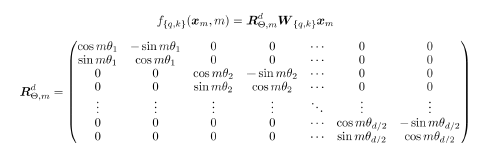

Burada theta parametresi yazarların belirttiği üzere 10000 ^ (-2(i-1) / d) formülü ile bulunur.

Yukarıdaki resimdeki sparse matris boş yere yer kaplayacağı ve bellekte ziyana yol açacağı için yukarıdaki işlemi şuna dönüştürebiliriz:

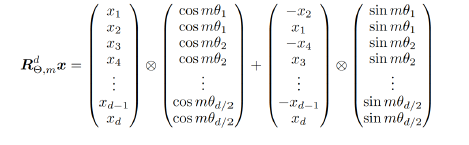


### Deepseek Modelinde Multi-Head Latent Attention Yaklaşımı ###

Deepseek modelinin diğer modellerden farklı olduğu bir kısım Multi-Head Latent Attention yaklaşımını geliştirmiş olmasıdır. Şöyle düşünelim: KV-Cache yapıyoruz. Toplam depolama alanı şu şekilde olur:

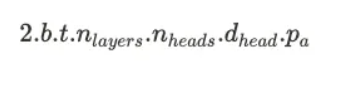

Bu formülde b batch_size'ı, t toplam dizi uzunluğunu (sequence_length), n_layers attention layer sayısını, n_heads ayrılan head sayısını, d_head bu headlerin boyutunu ve p_a ise precision'u temsil etmektedir. Bu parametreleri Deepseek modeli için yerine koyalım (Repodaki değişkenlerden yola çıkarak):
batch_size = 8 verilmiş
floating_point kısmı da bf16 olsa 2 byte olur dolayısıyla p_a = 2
key ve value dan dolayı çarpı 2 var
n_heads = 16
n_layers = 27
d_head = 128
context_size değeri de bu denli büyük modellerde 100.000 civarı dersek formüle göre:

2 * 8 * 100000 * 27 * 128 * 16 * 2 = 176947200000 byte = 176.9472 gb yapar. (Orijinal model parametrelerinde bu miktar yaklaşık 400gb olup context_size hariç diğer değerler GitHub reposundakilerden kullanıldığı için nispeten daha düşük çıkmıştır.)

Dolayısıyla bu yaklaşım ile bellekten aşırı kayıp sağlanır. Her ne kadar Mulihead Query Attention KV Cache'den 8 kat bellek tasarrufu sağlasa da Deepseek mühendisleri farklı bir yaklaşım geliştirmiştir.

Bu yaklaşım da Multi-Head Latent Attention'dur. Bu yaklaşımda latent space kullanılarak KV cache formülündeki 2 * n_heads * d_head kısmı azaltılması amaçlanmıştır. (Key-Query ayrı matris olmayacak ve boyutlar n_head * d_head değerinden daha düşük olacak)

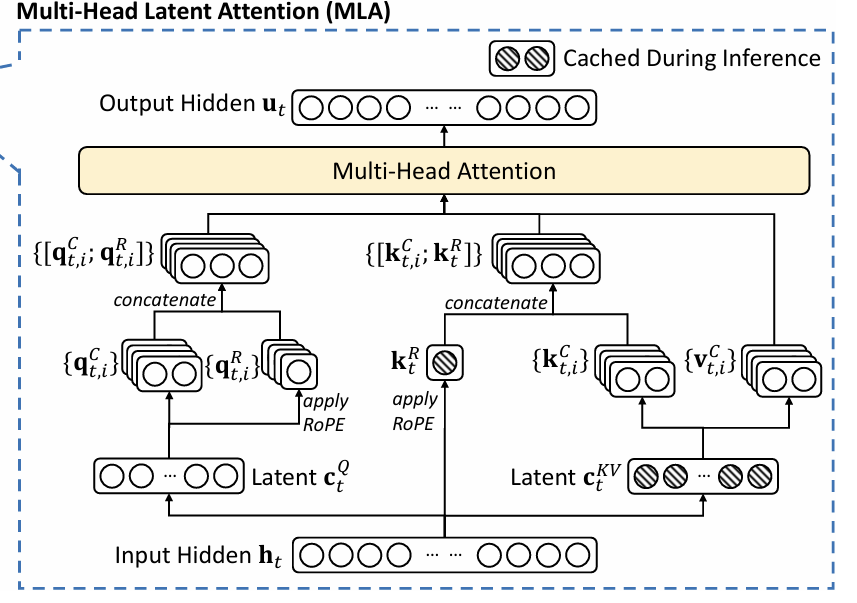

Latent Attention şu şekilde özetlenebilir:

X girdimize Query kısmında sıradan W_q matrisi uygulanır. (Önceki mimariler gibi yeni implementasyonlarda bu kısımda latent uzaya dönüştürülür.)
Key ve Value kısmı için ise latent uzaya çekilir (W_dkv matrisi ile. Bu kısmı C_kv olarak adlandıralım.)

Ardından Key ve Value değerleri için C_kv matrisi W_uk ve W_uv matrislerinden geçirilir. Dolayısıyla son durum şu şekilde olur:

Query = X W_q

C_k = X W_dkv

Key = C_k W_uk = X W_dkv W_uk

Value = C_k W_uv = X W_dkv W_uv

Burada Attention formülü uygulandığında: 

Query @ Key.T = (X W_q) (X W_dkv W_uk).T = (X W_q) (W_uk.T W_dkv.T X.T) = (X W_q W_uk.T)  (W_dkv.T X.T) olur eşitliğin birinci kısmı bir sefer hesaplanıp her sefer sabittir. İkinci kısım cache'e atılır. Bu sayede hesaplama ve depolama yüklerinden kurtulunur. Bu yönteme "absorption trick" denir.


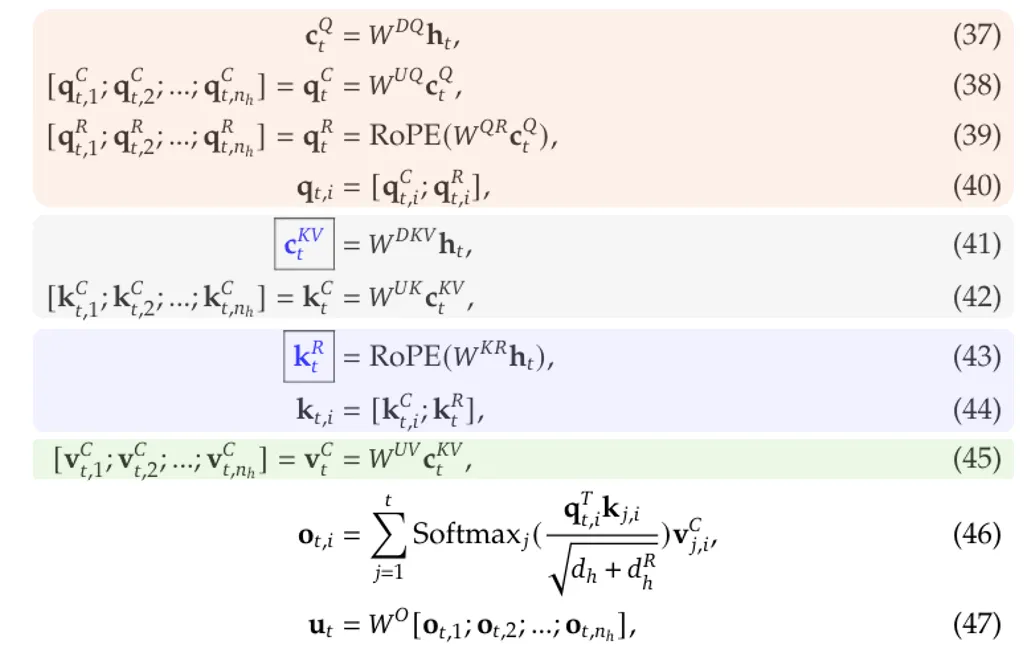

Bu Latent işlemi ile headlere ayırıp RoPE Embedding'i uygulayıp bu mekanizmayı elde ederiz.

In [ ]:
def precompute_freqs_cis(args: ModelArgs) -> torch.Tensor:
    """
    Rotary positional embeding için frekans tabanlı kompleks üstel değerleri önden hesaplar.

    Args:
        args (ModelArgs): Embedding parametrelerini içeren model argümanları.

    Returns:
        torch.Tensor: Positional embbeding için hesaplanmış kompleks üstel değerler.
    """
    dim = args.qk_rope_head_dim
    seqlen = args.max_seq_len
    beta_fast = args.beta_fast
    beta_slow = args.beta_slow
    base = args.rope_theta
    factor = args.rope_factor

    def find_correction_dim(num_rotations, dim, base, max_seq_len):
        """
        Verilen dönüş sayısı için Rotary Positional Embedding'teki düzeltme boyutunu hesaplar.
        Args:
            num_rotations (float): Düzeltmesi yapılacak dönüş miktarı.
            dim (int): Embedding uzayı boyutu.
            base (float): Üstel hesaplamanın taban değeri.
            max_seq_len (int): Maksimum dizi uzunluğu.

        Returns:
            float: Input parametredeki düzeltilmiş dönüş miktarı.
        """
        # Uzun dizilerde sinüs frekanslarını yaymaya çalışır. Uzun dizilerde RoPE açılarının daha yavaş dönmesini sağlar.
        # Bu ve bundan sonraki bir takım fonksiyonlar ileri seviye matematiksel ispat gerektirdiği için benim basit implementasyonumda yer almayacaklar.
        return dim * math.log(max_seq_len / (num_rotations * 2 * math.pi)) / (2 * math.log(base))

    def find_correction_range(low_rot, high_rot, dim, base, max_seq_len):
        """
        Rotary Positional Embbeding için düzeltme boyut aralığını hesaplar.
        Args:
            low_rot (float): Dönüş sayısının taban değeri.
            high_rot (float): Dönüş sayısının taban değeri.
            dim (int): Embedding uzay boyutu.
            base (float): Üssel hesaplama için taban değer.
            max_seq_len (int): Maksimum dizi uzunluğu.

        Returns:
            Tuple[int, int]: Geçerli indislere çekilmiş üzeltme boyutlarının aralığı (düşük, yüksek).
        """
        # Düzeltme boyutunu hesaplayıp aralığını hesapladık böylelikle düşük ve yüksek değerler için bu işlemleri gerçekleştirdik.
        low = math.floor(find_correction_dim(low_rot, dim, base, max_seq_len))
        high = math.ceil(find_correction_dim(high_rot, dim, base, max_seq_len))
        return max(low, 0), min(high, dim-1)

    def linear_ramp_factor(min, max, dim):
        """
        Minimum ve maksimum aralık arasındaki değerleri yumuşatmak için kullanılan doğrusal bir rampa fonksiyonunu hesaplar.
        Args:
            min (float): Rampa fonksiyonu için minimum değer.
            max (float): Rampa fonksiyonu için maksimum değer.
            dim (int): Rampa tensörü boyutu.

        Returns:
            Torch.Tensor: 0 ile 1 arasında doğrusal olarak
            interpole edilen değerlere sahip (dim) şeklinde bir tensör, [0, 1] aralığına sabitlenmiştir.
        """
        # min max eşitse eşitliği boz
        if min == max:
            max += 0.001
        # normalize edilmiş değeri rampa fonksiyonundan geçirip 0 - 1 aralığına sabitle
        linear_func = (torch.arange(dim, dtype=torch.float32) - min) / (max - min)
        ramp_func = torch.clamp(linear_func, 0, 1)
        return ramp_func

    # RoPE kısmında genellikle freqs değişkeninin olduğu yer ve t değişkeninin atandığı yerden itibaren kullanılır.
    freqs = 1.0 / (base ** (torch.arange(0, dim, 2, dtype=torch.float32) / dim))
    # Maksimum uzunluk orijinal uzunluğu geçtiği zaman yukarıda işlevlerini bahsettiğimiz fonksiyonları çağırarak frekansı yumuşak bir şekilde ayarlar.
    if seqlen > args.original_seq_len:
        low, high = find_correction_range(beta_fast, beta_slow, dim, base, args.original_seq_len)
        smooth = 1 - linear_ramp_factor(low, high, dim // 2)
        freqs = freqs / factor * (1 - smooth) + freqs * smooth
    # Klasik, hesaplanan frekanslarla seqlen uzunluğundaki tensörü outer ile seqlen, dim // 2 boyutlarına getirip polar düzleme al
    t = torch.arange(seqlen)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis


def apply_rotary_emb(x: torch.Tensor, freqs_cis: torch.Tensor) -> torch.Tensor:
    """
    Girdi tensörüne rotary embedding i uygular. (Attention'da query ve key).

    Args:
        x (torch.Tensor): Positional embedding uygulanacak girdi tensörü.
        freqs_cis (torch.Tensor): Önceden hesaplanmış üssel kompleks değerler..

    Returns:
        torch.Tensor: Rotary embedding uygulanmış tensör.
    """
    dtype = x.dtype
    # Girdiyi 2 li gruplara ayırıp kompleks hale getiririz. freqs_cis tensörünün boyutlarını düzenleyip çarpıp boyutlarını ayarlarız.
    # Bu işlemlerin hepsi Euler formülünden gelmektedir. Bundan dolayı kompleks uzayı ve polar düzlemi kullanırız.
    x = torch.view_as_complex(x.float().view(*x.shape[:-1], -1, 2))
    freqs_cis = freqs_cis.view(1, x.size(1), 1, x.size(-1))
    y = torch.view_as_real(x * freqs_cis).flatten(3)
    return y.to(dtype)

class MLA(nn.Module):
  def __init__(self, args:ModelArgs) -> None:
    """
    Multi-Head Latent Attention (MLA) Layer.

    Attributes:
        dim (int): Input boyutu.
        n_heads (int): Attention head sayısı.
        n_local_heads (int): Dağıtık sistemler için local attention head sayısı.
        q_lora_rank (int): Düşük rank query projeksiyonu.
        kv_lora_rank (int): Düşük rank key/value projeksiyonu.
        qk_nope_head_dim (int): Pozisyonel olmayan query/key boyutu.
        qk_rope_head_dim (int): Rotary-positional query/key boyutu.
        qk_head_dim (int): Total query/key projeksiyon boyutu.
        v_head_dim (int): Value projeksiyon boyutu.
        softmax_scale (float): Attention hesabında softmax fonksiyonu ölçü faktörü.
    """
    self.dim = args.dim
    self.n_heads = args.n_heads
    self.n_local_heads = args.n_heads // world_size
    self.q_lora_rank = args.q_lora_rank
    self.kv_lora_rank = args.kv_lora_rank
    self.qk_nope_head_dim = args.qk_nope_head_dim
    self.qk_rope_head_dim = args.qk_rope_head_dim
    self.qk_head_dim = args.qk_nope_head_dim + args.qk_rope_head_dim
    self.v_head_dim = args.v_head_dim
    # query'de latent uzayda sıkıştırmaya gitmezsek (Defaultta böyledir). Yoksa sıkıştırma uygularız.
    if self.q_lora_rank == 0:
      self.wq = nn.Linear(self.dim, self.n_heads * self.qk_head_dim)
    else:
      self.wq_a = nn.Linear(self.dim, self.q_lora_rank)
      self.q_norm = RMSNorm(self.q_lora_rank)
      # query up matrix
      self.wq_b = nn.Linear(self.q_lora_rank, self.n_heads * self.qk_head_dim)
    # context + position -> concat
    self.wkv_a = nn.Linear(self.dim, self.kv_lora_rank + self.qk_rope_head_dim)
    # latent kısım context i taşıdığı için ona RMSNorm uygulandı.
    self.kv_norm = RMSNorm(self.kv_lora_rank)
    # key up matrix
    self.wkv_b = nn.Linear(self.kv_lora_rank, self.n_heads * (self.qk_nope_head_dim + self.v_head_dim))
    self.wo = nn.Linear(self.n_heads * self.v_head_dim, self.dim)
    # Attention'daki formülde sqrt(dk) kısmını uygulamak için
    self.softmax_scale = self.qk_head_dim ** -0.5
    if args.max_seq_len > args.original_seq_len:
      # rope değerinin logunu alarak ve 0.1 ile çarparak yumual ayarlama
      mscale = 0.1 * args.mscale * math.log(args.rope_factor) + 1.0
      self.softmax_scale = self.softmax_scale * mscale ** 2
    #Key value ve positional encoding cache
    self.register_buffer("kv_cache", torch.zeros(args.max_batch_size, args.max_seq_len, self.kv_lora_rank), persistent=False)
    self.register_buffer("pe_cache", torch.zeros(args.max_batch_size, args.max_seq_len, self.qk_rope_head_dim), persistent=False)

  def forward(self, x: torch.Tensor, start_pos: int, freqs_cis: torch.Tensor, mask: Optional[torch.Tensor]):
    batch_size, seq_len, _ = x.size()
    end_pos = start_pos + seq_len
    if self.q_lora_rank == 0:
      q = self.wq(x)
    else:
      # (batch_size, seq_len, dim) -> (batch_size, seq_len, qk_lora) -> (batch_size, seq_len, n_heads * qk_head_dim)
      q = self.wq_b(self.q_norm(self.wq_a(x)))
    # (batch_size, seq_len, n_heads * qk_head_dim) -> (batch_size, seq_len, n_local_heads, qk_head_dim)
    q = q.view(batch_size, seq_len, self.n_local_heads, self.qk_head_dim)
    q_nope, q_pe = torch.split(q, [self.qk_nope_head_dim, self.qk_rope_head_dim], dim=-1)
    q_pe = apply_rotary_emb(q_pe, freqs_cis)
    # (batch_size, seq_len, dim) -> (batch_size, seq_len, kv_lora_rank + qk_rope_head_dim)
    kv = self.wkv_a(x)
    # kv -> (batch_size, seq_len, kv_lora_rank) k_pe -> (batch_size, seq_len, qk_rope_head_dim)
    kv, k_pe = torch.split(kv, [self.kv_lora_rank, self.qk_rope_head_dim], dim=-1)
    # (batch_size, seq_len, qk_rope_head_dim) -> (batch_size, seq_len, 1, qk_rope_head_dim)
    k_pe = apply_rotary_emb(k_pe.unsqueeze(2), freqs_cis)
    wkv_b = self.wkv_b.weight if self.wkv_b.scale is None else weight_dequant(self.wkv_b.weight, self.wkv_b.scale, block_size)
    wkv_b = wkv_b.view(self.n_local_heads, -1, self.kv_lora_rank)
    q_nope = torch.einsum("bshd,hdc->bshc", q_nope, wkv_b[:, :self.qk_nope_head_dim])
    self.kv_cache[:batch_size, start_pos:end_pos] = self.kv_norm(kv)
    # (batch_size, seq_len, 1, qk_rope_head_dim) -> (batch_size, seq_len, qk_rope_head_dim)
    self.pe_cache[:batch_size, start_pos:end_pos] = k_pe.squeeze(2)
    scores = (torch.einsum("bshc,btc->bsht", q_nope, self.kv_cache[:batch_size, :end_pos]) +
              torch.einsum("bshr,btr->bsht", q_pe, self.pe_cache[:batch_size, :end_pos])) * self.softmax_scale
    if mask is not None:
      scores += mask.unsqueeze(1)
    scores = scores.softmax(dim=-1, dtype=torch.float32).type_as(x)
    x = torch.einsum("bsht,btc->bshc", scores, self.kv_cache[:batch_size, :end_pos])
    x = torch.einsum("bshc,hdc->bshd", x, wkv_b[:, -self.v_head_dim:])
    x = self.wo(x.flatten(2))
    return x


In [ ]:
# Burada ekstra bir şey yok klasik MLP yapısı çok da üzerinde durmaya gerek yok
class MLP(nn.Module):
  def __init__(self, dim: int, inter_dim: int) -> None:
    super().__init__()
    self.dim = dim
    self.inter_dim = inter_dim
    self.w1 = nn.Linear(self.dim, self.inter_dim)
    self.w2 = nn.Linear(self.inter_dim, self.dim)
    self.w3 = nn.Linear(self.dim, self.inter_dim)
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    x = F.silu(self.w1(x)) * self.w3(x)
    x = self.w2(x)
    return x

Son olarak MoE(Mixture of Experts) yapısına gelelim. Klasik transformer mimarisinde her token aynı ağırlıklarla işlenir yani her token Feed Forward'tan geçer. Bu yaklaşım klasik bir yaklaşım olup Yapay Zeka'nın temel yaklaşımıdır. MoE yaklaşımı bu yaklaşımı Doğal Dil İşleme bazında geliştirmiştir. MoE ile her token uzman ağlara yönlendirilir. Her token kendine uygun uzmanlarla işlenir. Bu sayede her geçişte daha az parametre aktif olur. 

MoE katmanında üç ana bileşen vardır. Bunlar:

* Router: Her tokenın embedding'ine bakarak hangi uzmana gönderileceğini seçer. 
* Experts: Her biri kendi feed-forward bloğuna sahip alt modellerdir.
* Combiner: Router'ın skorlarına göre seçilen çıktıları toplar. 

MoE yapısında olaylar aşağı yukarı şu şekilde gelişir: 
Girdiye göre router expert sayısı kadar yönlendirme yapar. (nn.Linear aracılığıyla). Bu expertler softmaxten geçirilerek olasılıklandırılır ve bu olasılıklardan topk adet seçim yapılır. Bir taraftan da girdi kadar boş tensör oluşturulur.(Ağırlıklandırmada kullanılacak.) Her bir expert içerisinde topk adet seçilen olasılıkların indisleri ve değerleri tutulu, maskelenir ve girdi boyutundaki boş tensör yeni ağırlıklarla doldurulur ve yeni girdi dönülür.

In [ ]:
class Gate(nn.Module):
 """
    Mixture of Experts (MoE) modeli için Gating mekanizması.

    Değişkenler:
        dim (int): Input feature boyutu.
        topk (int): Her input için aktive edilen k expert.
        n_groups (int): Route edilecek grup sayısı.
        topk_groups (int): Girişlerin yönlendirileceği grup sayısı.
        score_func (str): Skor fonksiyonu (softmax ya da sigmoid).
        route_scale (float): Routing ağırlıkları için ölçekleme faktörü.
        weight (torch.nn.Parameter): Gate (kapı) için öğrenilebilir ağırlıklar.
        bias (Optional[torch.nn.Parameter]): Gate (Kapı) için opsiyonel bias parametresi.
    """
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.dim = args.dim
        self.topk = args.n_activated_experts
        # Bazı MoE tasarımlarında uzmanlar gruplara ayrılır. Bu değişken de onu göstermektedir.
        self.n_groups = args.n_expert_groups
        # Kaç grubun aktif olacağını gösterir.
        self.topk_groups = args.n_limited_groups
        # Routing için kullanılan puanlama fonksiyonu
        self.score_func = args.score_func
        self.route_scale = args.route_scale
        # Her uzmanın ağırlıkları ve biasları. Her uzmanın olduğu için n_routed_experts kullanılır.
        self.weight = nn.Parameter(torch.empty(args.n_routed_experts, args.dim))
        self.bias = nn.Parameter(torch.empty(args.n_routed_experts, dtype=torch.float32)) if self.dim == 7168 else None

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """

        Args:
            x (torch.Tensor): Input tensörü.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Routing ağırlıkları ve seçilen expert indisler.
        """
        # Gelen tensörü linearden geçirerek skoru bulur ardından skor fonksiyonunu uygular.
        scores = F.linear(x, self.weight)
        if self.score_func == "softmax":
            scores = scores.softmax(dim=-1, dtype=torch.float32)
        else:
            scores = scores.sigmoid()
        original_scores = scores
        # Bias None değilse skora ekler.
        if self.bias is not None:
            scores = scores + self.bias
        # Grup sayım 1'den büyükse skoru n_groups adet yapar.
        if self.n_groups > 1:
            scores = scores.view(x.size(0), self.n_groups, -1)
            # Bias değeri None'sa group_scores kısmına son boyutta (muhtemelen n_experts_per_group kadar) en yüksek skoru veren expertleri alacak
            if self.bias is None:
                group_scores = scores.amax(dim=-1)
            else:
                # Yoksa en yüksek 2 tanesinin skorlarını al ve topla (batch başı)
                group_scores = scores.topk(2, dim=-1)[0].sum(dim=-1)
            # Burada da indislerini al.
            indices = group_scores.topk(self.topk_groups, dim=-1)[1]
            # x.size(0), n_groups boyutlarında bir maske oluştur ve aktif indisleri false yap
            mask = scores.new_ones(x.size(0), self.n_groups, dtype=bool).scatter_(1, indices, False)
            # True olan yerleri -inf ile doldur. (Softmaxten 0 çıkar.) ve flatten ile düzle
            scores = scores.masked_fill_(mask.unsqueeze(-1), float("-inf")).flatten(1)
        # Skor değerlerinin indislerini al
        indices = torch.topk(scores, self.topk, dim=-1)[1]
        # original_scores değişkenindeki indislerle çakışan değerleri al
        weights = original_scores.gather(1, indices)
        # skor fonksiyonuna göre ağırlığı scale et ve indislerle beraber dön
        if self.score_func == "sigmoid":
            weights /= weights.sum(dim=-1, keepdim=True)
        weights *= self.route_scale
        return weights.type_as(x), indices


class Expert(nn.Module):
    """
    Bu kısım MLP katmanına benzemektedir.
    """
    def __init__(self, dim: int, inter_dim: int):
        super().__init__()
        self.w1 = nn.Linear(dim, inter_dim)
        self.w2 = nn.Linear(inter_dim, dim)
        self.w3 = nn.Linear(dim, inter_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.w2(F.silu(self.w1(x)) * self.w3(x))


In [ ]:
class MoE(nn.Module):
    """
    Mixture-of-Experts (MoE) modülü.

    Attributes:
        dim (int): Input'taki boyut.
        n_routed_experts (int): Modeldeki toplam expert sayısı.
        n_local_experts (int): Dağıtık sistemlerde handle edilen expert sayısı.
        n_activated_experts (int): Her bir input için expert sayısı.
        gate (nn.Module): Inputları expertlere yönlendiren Gating mekanizması.
        experts (nn.ModuleList): Expert modül listesi.
        shared_experts (nn.Module): Tüm inputlarla paylaşılan expertler.
    """
    def __init__(self, args: ModelArgs):
        """
        Initializes the MoE module.

        Args:
            args (ModelArgs): Model arguments containing MoE parameters.
        """
        super().__init__()
        self.dim = args.dim
        # Route edilen expert sayısı world_size' a yani GPU sayısına tam bölünmelidir. Çünkü GPU'lara dağıtılacak.
        assert args.n_routed_experts % world_size == 0, f"Number of experts must be divisible by world size (world_size={world_size})"
        self.n_routed_experts = args.n_routed_experts
        # GPU başı expert sayısı
        self.n_local_experts = args.n_routed_experts // world_size
        self.n_activated_experts = args.n_activated_experts
        self.experts_start_idx = rank * self.n_local_experts
        self.experts_end_idx = self.experts_start_idx + self.n_local_experts
        self.gate = Gate(args)
        self.experts = nn.ModuleList([Expert(args.dim, args.moe_inter_dim) if self.experts_start_idx <= i < self.experts_end_idx else None
                                      for i in range(self.n_routed_experts)])
        self.shared_experts = MLP(args.dim, args.n_shared_experts * args.moe_inter_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        shape = x.size()
        x = x.view(-1, self.dim)
        weights, indices = self.gate(x)
        y = torch.zeros_like(x)
        # topk den gelen indis listesini flatten ile düzleştirip count unu alır. Böylelikle hangi experte kaç tane token gidecek anlaşılır.
        counts = torch.bincount(indices.flatten(), minlength=self.n_routed_experts).tolist()
        # Hiçbir expert e token gitmezse orayı atlar expert e giden token ı expert in ilgili yerine yollar.
        for i in range(self.experts_start_idx, self.experts_end_idx):
            if counts[i] == 0:
                continue
            expert = self.experts[i]
            # idx burada satır top ise o satırda kaçıncı sırada olduğunu döner.
            idx, top = torch.where(indices == i)
            # Tokenlar uzman ağına gider ve ağırlıklandırılır.
            y[idx] += expert(x[idx]) * weights[idx, top, None]
        z = self.shared_experts(x)
        # Dağıtık GPU ortamı varsa bütün sonuçları al ve topla
        if world_size > 1:
            dist.all_reduce(y)
        return (y + z).view(shape)


In [ ]:
class Block(nn.Module):
    """
    Attention ve feed-forward ağından oluşan Transformer bloğu.

    Attributes:
        attn (nn.Module): Attention layer (MLA).
        ffn (nn.Module): Feed-forward network (MLP ya da MoE).
        attn_norm (nn.Module): Attention için Layer normalization.
        ffn_norm (nn.Module): FFN için Layer normalization.
    """
    def __init__(self, layer_id: int, args: ModelArgs):
        """
        Args:
            layer_id (int): Transformerdaki Layer index.
            args (ModelArgs): Blok parametrelerini içeren model argümanları.
        """
        super().__init__()
        self.attn = MLA(args)
        self.ffn = MLP(args.dim, args.inter_dim) if layer_id < args.n_dense_layers else MoE(args)
        self.attn_norm = RMSNorm(args.dim)
        self.ffn_norm = RMSNorm(args.dim)

    def forward(self, x: torch.Tensor, start_pos: int, freqs_cis: torch.Tensor, mask: Optional[torch.Tensor]) -> torch.Tensor:
        """
        Forward pass for the Transformer block.

        Args:
            x (torch.Tensor): Input tensor.
            start_pos (int): Dizideki başlangıç pozisyonu.
            freqs_cis (torch.Tensor): Rotary Embedding için önceden hesaplanmış karmaşık üssel değerler.
            mask (Optional[torch.Tensor]): Attentiondaki belli pozisyonları hariç tutmak için maske.

        Returns:
            torch.Tensor: Blok hesaplamadan çıkan output tensörü.
        """
        # Residual Connection
        x = x + self.attn(self.attn_norm(x), start_pos, freqs_cis, mask)
        x = x + self.ffn(self.ffn_norm(x))
        return x


In [ ]:
class Transformer(nn.Module):
    """
    Oluşan Deepseek yapısı.

    Attributes:
        max_seq_len (int): Transformer için maksimum diziuzunluğu.
        embed (nn.Module): Input tokenları için embedding layer.
        layers (torch.nn.ModuleList): Transformer blok listesi.
        norm (nn.Module): Bloklara uygulanan normalizasyon.
        head (nn.Module): Sözlük boyutuna eşleyen projeksiyon katmanı.
        freqs_cis (torch.Tensor): Rotary Embedding için önceden hesaplanmış karmaşık üssel değerler.
    """
    def __init__(self, args: ModelArgs):
        global world_size, rank
        world_size = dist.get_world_size() if dist.is_initialized() else 1
        rank = dist.get_rank() if dist.is_initialized() else 0
        super().__init__()
        self.max_seq_len = args.max_seq_len
        self.embed = nn.Embedding(args.vocab_size, args.dim)
        self.layers = torch.nn.ModuleList()
        for layer_id in range(args.n_layers):
            self.layers.append(Block(layer_id, args))
        self.norm = RMSNorm(args.dim)
        self.head = nn.Linear(args.dim, args.vocab_size, dtype=torch.get_default_dtype())
        self.register_buffer("freqs_cis", precompute_freqs_cis(args), persistent=False)

    @torch.inference_mode()
    def forward(self, tokens: torch.Tensor, start_pos: int = 0):
        """
        Args:
            tokens (torch.Tensor): (batch_size, seq_len) boyutunda token ID si içeren input tensör.
            start_pos (int, optional): Dizinin rotary embedding için başlangıç pozisyonu.Default 0.

        Returns:
            torch.Tensor: (batch_size, vocab_size) boyutunda logit.
        """
        # seqlen i girdiden alıp tokenları embeddingten geçirdik. Ayrıca freqs_cis tensörüne başlangıç bitiş kısımlarından kırptık.
        # seqlen > 1 olduğu durumda kare matris oluşturduk (seqlen, seqlen) üst üçgenini sıfırladık. (Softmaxte -inf = 0)
        # layerlardan geçirip normalize ettik. GPU sayımız 1 den fazlaysa bu işlemleri bütün GPU'larda yapıp toplayıp birleştirdik.
        # en sonda da logits i döndük.
        seqlen = tokens.size(1)
        h = self.embed(tokens)
        freqs_cis = self.freqs_cis[start_pos:start_pos+seqlen]
        mask = None
        if seqlen > 1:
            mask = torch.full((seqlen, seqlen), float("-inf"), device=tokens.device).triu_(1)
        for layer in self.layers:
            h = layer(h, start_pos, freqs_cis, mask)
        h = self.norm(h)[:, -1]
        logits = self.head(h)
        if world_size > 1:
            all_logits = [torch.empty_like(logits) for _ in range(world_size)]
            dist.all_gather(all_logits, logits)
            logits = torch.cat(all_logits, dim=-1)
        return logits

In [ ]:
torch.set_default_dtype(torch.bfloat16)
torch.set_default_device("cuda")
torch.manual_seed(0)
args = ModelArgs()
x = torch.randint(0, args.vocab_size, (2, 128))
model = Transformer(args)
print(model(x).size())

Bu kodta ColumnParallel, Linear gibi sınıflar atlanmıştır. 

Şimdi bizim yorumumuza gelelim.

In [ ]:
import torch
import math
from torch import nn
import torch.nn.functional as F


class RoPE(nn.Module):
  def __init__(self, d_head:int, seq_len:int=2048, base:float=10000.0) -> None:
    super().__init__()
    self.d_head = d_head
    self.seq_len = seq_len
    self.base = base
    self.i = torch.arange(0, self.d_head, 2).float()
    self.theta = 1.0 / self.base ** (self.i / self.d_head)
    self.pos = torch.arange(0, self.seq_len)
    self.freqs = self.pos.unsqueeze(1) * self.theta.unsqueeze(0)
    freqs_cis = torch.polar(torch.ones_like(self.freqs), self.freqs)
    self.register_buffer('freqs_cis', freqs_cis)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    # x shape: (batch_size, n_heads, seq_len, d_head)
    seq_len = x.shape[-2]
    freqs_cis = self.freqs_cis[:seq_len]  # (seq_len, d_head//2)
    x_complex = x.float().reshape(*x.shape[:-1], -1, 2)  # (..., seq_len, d_head//2, 2)
    x_complex = torch.view_as_complex(x_complex)  # (..., seq_len, d_head//2)
    freqs_cis = freqs_cis.unsqueeze(0).unsqueeze(0)
    x_rotated = x_complex * freqs_cis
    y = torch.view_as_real(x_rotated).flatten(-2)  # (..., seq_len, d_head)

    return y

class MLA(nn.Module):
  def __init__(self, dim:int, n_heads:int, kv_lora:int, qk_rope:int) -> None:
    super().__init__()
    self.dim = dim
    self.n_heads = n_heads
    assert self.dim % self.n_heads == 0, "dim n_heads sayısına tam bölünmelidir..."
    self.d_head = dim // self.n_heads
    self.qk_rope = qk_rope
    self.kv_lora = kv_lora

    # Context
    self.wq = nn.Linear(self.dim, self.dim, bias = False)
    self.W_dkv = nn.Linear(self.dim, self.kv_lora, bias = False)
    self.upk = nn.Linear(self.kv_lora, self.dim, bias = False)
    self.upv = nn.Linear(self.kv_lora, self.dim, bias = False)
    self.wo = nn.Linear(self.dim, self.dim, bias = False)

    # Rope
    self.W_q_pos = nn.Linear(self.dim, self.qk_rope * self.n_heads)
    self.W_k_pos = nn.Linear(self.dim, self.qk_rope * self.n_heads)
    self.rope = RoPE(d_head=self.qk_rope, seq_len=2048)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    batch_size, seq_len, dim = x.shape
    # (batch_size, seq_len, dim) -> (batch_size, n_heads, seq_len, d_head)
    q = self.wq(x).view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)
    # (batch_size, seq_len, dim) -> (batch_size, seq_len, kv_lora)
    c_k = self.W_dkv(x)
    # (batch_size, seq_len, kv_lora) -> (batch_size, seq_len, dim) -> (batch_size, n_heads, seq_len, d_head)
    k_context = self.upk(c_k).view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)
    v_context = self.upv(c_k).view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)
    # Positional
    #(batch_size, seq_len, dim) -> (batch_size, n_heads, seq_len, qk_rope)
    q_rope = self.W_q_pos(x).view(batch_size, seq_len, self.n_heads, self.qk_rope).transpose(1, 2)
    k_rope = self.W_k_pos(x).view(batch_size, seq_len, self.n_heads, self.qk_rope).transpose(1, 2)

    q_rope = self.rope(q_rope)
    k_rope = self.rope(k_rope)

    # Transformer
    #(batch_size, n_heads, seq_len, d_head) @ (batch_size, n_heads, d_head, seq_len) -> (batch_size, n_heads, seq_len, seq_len)
    attn_cont = q @ k_context.transpose(-2, -1) / math.sqrt(self.d_head)
    # (batch_size, n_heads, seq_len, qk_rope) @ (batch_size, n_heads, qk_rope, seq_len) -> (batch_size, n_heads, seq_len, seq_len)
    attn_pos = q_rope @ k_rope.transpose(-2, -1) / math.sqrt(self.qk_rope)
    attn_scores = attn_cont + attn_pos
    self.register_buffer('mask', torch.triu(torch.ones(1, 1, seq_len, seq_len), diagonal = 1).bool())
    scores = attn_scores.masked_fill(self.mask, float('-inf'))
    attn_probs = F.softmax(scores, dim = -1)
    # (batch_size, n_heads, seq_len, seq_len) @ (batch_size, n_heads, seq_len, d_head) -> (batch_size, n_heads, seq_len, d_head)
    attn_out = (attn_probs @ v_context).transpose(1, 2).contiguous().view(batch_size, seq_len, dim)
    attn_out = self.wo(attn_out)
    return attn_out

In [ ]:
# Deepseek'teki MoE mimarisinin basit hali. Burada shared_experts, routed ve activated_experts yok.
class MoE(nn.Module):
  def __init__(self, dim:int, hidden_dim:int, num_experts:int = 4, top_k:int = 2) -> None:
    super().__init__()
    self.num_experts = num_experts
    self.top_k = top_k
    # Expertlere yönlendiren kapı
    self.gate = nn.Linear(dim, num_experts, bias = False)
    self.experts = nn.ModuleList([
        nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        ) for _ in range(num_experts)
    ])

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    batch_size, seq_len, dim = x.shape
    # (batch_size, seq_len, dim) -> (batch_size, seq_len, num_experts)
    gate_logits = self.gate(x)
    gate_scores = F.softmax(gate_logits, -1)
    # En yüksek skoru veren tokenları seç topk kadar.
    topk_scores, topk_idx = torch.topk(gate_scores, self.top_k, dim = -1)
    # (batch_size, seq_len, dim) Ağırlıklandırılmış yeni x değerlerini tutar.
    y = torch.zeros_like(x)
    for i in range(self.top_k):
      # (batch_size, seq_len)
      idx = topk_idx[..., i]
      # (batch_size, seq_len, 1)
      score = topk_scores[..., i].unsqueeze(-1)
      # Expert içinde gezmek için
      for e_id, expert in enumerate(self.experts):
        # (batch_size, seq_len, 1)
        mask = (idx == e_id).unsqueeze(-1)     # (B,T,1)
        if mask.any():
          y[mask.expand_as(x)] += (score * expert(x))[mask.expand_as(x)]
    return y

In [ ]:
class DeepSeekBlock(nn.Module):
    def __init__(self, dim: int, n_heads: int, kv_lora: int, qk_rope_dim: int,
                 mlp_ratio: float = 4.0, num_experts: int = 4, top_k: int = 2):
        super().__init__()
        self.ln1 = nn.RMSNorm(dim)
        self.attn = MLA(dim, n_heads, kv_lora, qk_rope_dim)
        self.ln2 = nn.RMSNorm(dim)
        hidden_dim = int(dim * mlp_ratio)
        self.moe = MoE(dim, hidden_dim, num_experts, top_k)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.moe(self.ln2(x))
        return x


class DeepSeekMini(nn.Module):
    def __init__(self, vocab_size=32000, dim=512, n_layers=6, n_heads=8,
                 kv_lora=64, qk_rope_dim=64, num_experts=4, top_k=2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, dim)
        self.layers = nn.ModuleList([
            DeepSeekBlock(dim, n_heads, kv_lora, qk_rope_dim,
                          mlp_ratio=4.0, num_experts=num_experts, top_k=top_k)
            for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, vocab_size, bias=False)

    def forward(self, idx):
        x = self.embed(idx)
        for layer in self.layers:
            x = layer(x)
        x = self.ln_f(x)
        return self.head(x)

In [ ]:
B, T, vocab = 2, 16, 10000
model = DeepSeekMini(vocab_size=vocab, dim=256, n_layers=2, n_heads=4,
                     kv_lora=64, qk_rope_dim=32, num_experts=4, top_k=2)
inp = torch.randint(0, vocab, (B, T))
out = model(inp)
print(out.shape)  # -> torch.Size([2, 16, 10000])


torch.Size([2, 16, 10000])
